---
title: "How Fine is FineWeb2?"
description: "Analysis of the FineWeb-C dataset"
author: "Daniel van Strien"
date: "2025-01-07"
categories: ["polars", "huggingface", "fineweb"]
image: https://huggingface.co/datasets/HuggingFaceFW/admin/resolve/main/fineweb-2-logo.png
toc-depth: 3
---

Recently [FineWeb2](https://huggingface.co/datasets/HuggingFaceFW/fineweb-2) was released, adding multilingual data to the original FineWeb dataset. As part of the [FineWeb-C community initiative](https://huggingface.co/blog/davanstrien/fineweb2-community), contributors have been annotating samples from this dataset to assess educational quality across different languages. 

The goal of this effort is to reproduce something similar to the original [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) dataset for all languages. You can read more about why this is important in the [FineWeb-C blog post](https://huggingface.co/blog/davanstrien/fineweb2-community).


### Analyzing the FineWeb-C Community Annotations

This post examines the annotation data collected so far through the FineWeb-C project. For most languages, community members have annotated random samples of approximately 1,000 examples from FineWeb2. The annotations focus on:

- Educational value assessment
- Language identification verification
- Problematic content flagging


Let's explore what the community annotations tell us about the quality and characteristics of content across different languages in FineWeb2.

We'll start by installing the necessary libraries. 


In [1]:
# | output: false
%pip install polars seaborn matplotlib huggingface_hub 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# | output: false
import polars as pl
from huggingface_hub import list_repo_files

# bump up the number of rows in the polars table so we can see more data
pl.Config.set_tbl_rows(100)

polars.config.Config

We'll use Polars to load the annotations but we could also load in Pandas, Dask, DuckDB, PySpark, or the Hugging Face Datasets library!

The fineweb-c dataset has a config per language but also a general config. We'll load all the parquet files for each language, which we can get using the `list_repo_files` function from the `huggingface_hub` library.


In [3]:
paths = list_repo_files("data-is-better-together/fineweb-c", repo_type="dataset")
paths = [f for f in paths if f.endswith(".parquet") and "data" not in f]
paths

['arb_Arab/train-00000-of-00001.parquet',
 'ary_Arab/train-00000-of-00001.parquet',
 'arz_Arab/train-00000-of-00001.parquet',
 'asm_Latn/train-00000-of-00001.parquet',
 'bar_Latn/train-00000-of-00001.parquet',
 'cmn_Hani/train-00000-of-00001.parquet',
 'dan_Latn/train-00000-of-00001.parquet',
 'fas_Arab/train-00000-of-00001.parquet',
 'fil_Latn/train-00000-of-00001.parquet',
 'fin_Latn/train-00000-of-00001.parquet',
 'fra_Latn/train-00000-of-00001.parquet',
 'gmh_Latn/train-00000-of-00001.parquet',
 'hin_Deva/train-00000-of-00001.parquet',
 'lvs_Latn/train-00000-of-00001.parquet',
 'rus_Cyrl/train-00000-of-00001.parquet',
 'slk_Latn/train-00000-of-00001.parquet',
 'swe_Latn/train-00000-of-00001.parquet',
 'tat_Cyrl/train-00000-of-00001.parquet',
 'ukr_Cyrl/train-00000-of-00001.parquet',
 'vie_Latn/train-00000-of-00001.parquet']

In [4]:
df = pl.scan_parquet(
    [f"hf://datasets/data-is-better-together/fineweb-c/{p}" for p in paths]
)

### How many languages are included in the dataset so far? 

In [5]:
df.select(pl.col("language_code")).unique().collect().count()

language_code
u32
20


We can also see how many rows there are per language. 


In [6]:
df.group_by(["language_code"]).agg(pl.col("id").len().alias("n_rows")).sort(
    "n_rows", descending=True
).collect()

language_code,n_rows
str,u32
"""tat_Cyrl""",1865
"""fil_Latn""",1000
"""fin_Latn""",1000
"""gmh_Latn""",1000
"""ukr_Cyrl""",1000
"""hin_Deva""",1000
"""arb_Arab""",1000
"""arz_Arab""",1000
"""slk_Latn""",1000


We could also directly use the datasets viewer to get this information! This can be a really useful way to explore the data very quickly without having to load it locally.

<iframe src="https://huggingface.co/datasets/data-is-better-together/fineweb-c/embed/sql-console/rroUpCS" frameborder="0" width="100%" height="560px"></iframe>

## Number of annotators

Since starting this project we've found some languages have had more problematic data, including languages where a lot of data was identified in the wrong language. Because of this for some languages we've set a higher or lower "retirement" threshold before retiring a sample. This means some languages have only a single annotator labeling each example whilst others have had multiple people annotate each example. 

Let's look at the mean number of annotators per language.


In [7]:
df.group_by(["language_code"]).agg(
    pl.col("educational_value_labels").list.len().mean().alias("n_annotators")
).sort("n_annotators", descending=True).collect()

language_code,n_annotators
str,f64
"""vie_Latn""",2.869
"""dan_Latn""",2.573
"""ary_Arab""",1.019
"""fin_Latn""",1.017
"""fra_Latn""",1.012
"""slk_Latn""",1.006
"""swe_Latn""",1.006
"""arz_Arab""",1.006
"""tat_Cyrl""",1.003217


Ideally as we progress with the project we'll increase the overlap at least for some time to see how much annotators agree (more on this below) but we also don't want people to spend a lot of time annotating the same sample if it's of low quality. 

### Look at the distribution of labels

No we've got a sense of how many annotators there are per language, let's look at the distribution of labels. Since we sometimes have multiple labels for each sample we'll simplify things a bit to just look at the first label for each sample. For some languages this will be the only label anyway. If we work with a specific language for a longer time we'll also want to consider the agreement between annotators.

In [8]:
df = df.with_columns(
    pl.col("educational_value_labels").list.first().alias("label")
).collect()
df.head(1)

id,text,educational_value_labels,annotator_ids,problematic_content_label_present,problematic_content_label_agreement,language_names,language_code,label
str,str,list[str],list[str],bool,f64,str,str,str
"""78889051-5d7e-4d33-9d3f-6414ba…","""المؤتمر العالمي للغابات يجتمع …","[""None""]","[""9e779e60-6719-401a-ab47-05aafb94be65""]",false,1.0,"""arb_Arab""","""arb_Arab""","""None"""


In [9]:
# | code-fold: true
# | code-summary: "Click to show/hide code"
# | input: false
label_counts = (
    df.group_by(["language_code", "label"])
    .len()
    .pivot(
        values="len",
        index="language_code",
        on="label",
        aggregate_function="sum",
    )
    .fill_null(0)
)

# Calculate row totals
row_totals = label_counts.select(pl.exclude("language_code")).sum_horizontal()

# Calculate percentages
label_percentages = (
    label_counts.with_columns(
        pl.col(col) / row_totals * 100
        for col in label_counts.columns
        if col != "language_code"
    )
    .select(["language_code", pl.all().exclude("language_code").round(2)])
    .sort("language_code")
)

label_percentages

language_code,Excellent,Good,None,Minimal,Basic,❗ Problematic Content ❗,❗ Wrong language ❗
str,f64,f64,f64,f64,f64,f64,f64
"""arb_Arab""",0.7,2.5,51.0,15.6,4.9,25.3,0.0
"""ary_Arab""",1.0,1.4,1.1,1.2,0.7,94.6,0.0
"""arz_Arab""",2.0,4.0,12.7,3.7,4.1,73.5,0.0
"""asm_Latn""",0.0,0.0,64.7,5.0,0.3,19.1,10.9
"""bar_Latn""",0.0,0.0,16.5,2.4,4.1,77.0,0.0
"""cmn_Hani""",1.4,9.7,24.2,36.2,25.1,2.5,0.9
"""dan_Latn""",0.1,1.2,47.6,28.2,8.4,14.5,0.0
"""fas_Arab""",2.3,8.9,39.6,18.7,10.0,20.5,0.0
"""fil_Latn""",0.8,2.6,24.1,27.6,5.1,37.9,1.9


This is a bit hard to read so let's plot it as a heatmap. 



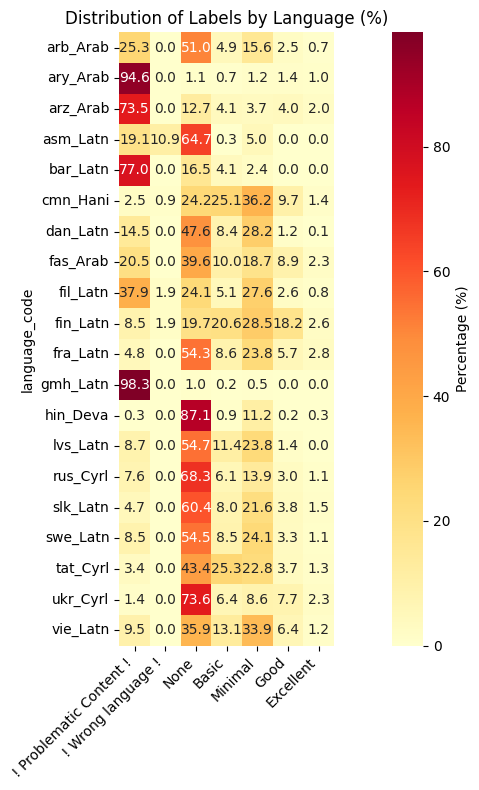

In [10]:
# | code-fold: true
# | code-summary: "Click to show/hide code"
# | input: false
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Polars DataFrame to pandas for seaborn
label_percentages_pd = label_percentages.to_pandas()

# Clean up column names by replacing the problematic symbols
label_percentages_pd.columns = [
    col.replace("❗", "!") for col in label_percentages_pd.columns
]

# Define the desired column order
column_order = [
    "! Problematic Content !",
    "! Wrong language !",
    "None",
    "Basic",
    "Minimal",
    "Good",
    "Excellent",
]

# Reorder the columns (excluding 'language_code' which will be the index)
label_percentages_pd = label_percentages_pd.set_index("language_code")[column_order]

plt.figure(figsize=(12, 8))

sns.heatmap(
    label_percentages_pd,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Percentage (%)"},
    square=True,
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title("Distribution of Labels by Language (%)")
plt.tight_layout()
plt.show()

We can also look at the distribution of labels as a bar chart. 


In [11]:
# | code-fold: true
# | code-summary: "Click to show/hide code"
# | input: false
import altair as alt

# Convert the wide-format data to long format for Altair
plot_df = label_percentages.unpivot(
    index=["language_code"],
    on=label_percentages.columns[1:],  # All columns except language_code
    variable_name="label",
    value_name="percentage",
)

# Create the Altair chart
chart = (
    alt.Chart(plot_df)
    .mark_bar()
    .encode(
        x="language_code",
        y=alt.Y("percentage", stack="zero"),
        color="label",
        tooltip=["language_code", "label", "percentage"],
    )
    .properties(width=600, height=400, title="Label Distribution by Language")
    .configure_axis(labelAngle=45)
)

chart

alt.Chart(...)


## Refining FineWeb2 for more languages aka next steps

We can see that the distribution of labels varies a fair amount between languages. Some are mostly problematic labels whilst others have a much better distribution of labels. This can also inform what is the best next step for a languages as part of the FineWeb-C project.

### Better starting data for annotators aka more filtering of problematic data

FineWeb2 already has a lot of filters to try and identify high quality data, however this is challenging to do across many many languages. This is why the community is so important. 

- If a language has a lot of problematic or None labels it makes sense to focus on getting higher quality data filtered for that language. 
- In a previous [blog post](https://danielvanstrien.xyz/posts/2024/12/23/fineweb-filter-polars.html) I showed some approaches to how this can be done for a single language. The best approach will depend on the language but developing better heuristics for more languages can be very impactful. **This is another area where the community can help!**
- Some languages have a lot of data that has been incorrectly identified as the wrong language. This is a problem for the community as it means annotators have to spend a lot of time annotating data that is not useful. For these languages **if the community has better heuristics or models for identifying the wrong language we can filter out more data.**

### Evaluating agreement between annotators
If a language has a good distribution of labels the next step is to try and look at the agreement between annotators. This can help us understand how much we can trust the labels and also help us understand where the labels are ambiguous. 

### Evaluating LLMs to build training data for a classifier?

For languages where we have fairly good agreement (or at least a subset of good agreement) we can already start to evaluate how well LLMs can do at identifying educational content. Remembering back to the overall goal of this effort, is to reproduce something similar to FineWeb-Edu. This is a subset of the original FineWeb dataset which has been filtered for educational content. This filtering was done by first training a classifier on the original FineWeb-Edu dataset and then using this classifier to filter the original FineWeb dataset. That classifier was training on labels generated by Llama. For some languages it might be possible to take a similar approach. We can do something like:

- Evaluate how well an LLM does in comparison to our annotators. This might require experimenting with different LLMs and prompting approaches. I'm working on a notebook to do this but **this is another area where the community can help.**
- If the LLM does a good job we can then use it to create enough data to start to train a classifier. 

### Training educational quality classifiers

Some languages already have quite a lot of data with a fairly good distribution of labels. For these languages we can already see if we have sufficient data to train a classifier. It's likely for most languages we'd need more data but starting to train a classifier can be a good next step. **Again this is another area where the community can help!**

As you may have noticed, I've been using the word "community" a lot in this post. This is because I think this is a really important part of the FineWeb-C project. We have a [Discord channel](https://discord.com/channels/879548962464493619/1326130187527651348) where we can discuss the project and share ideas. If you're interested in contributing to the project please join the channel and let's chat!